## Algoritmos de optimización con menos generaciones

#### Selección de parámetros

In [1]:
N_GENERATIONS = 20

In [3]:
import pandas as pd
import numpy as np
from preprocesamiento import bases_de_datos as bbdd
from modelado import funcs_modelado as opt

N_INDIVIDUOS = 100
MUTATION_RATE = 0.2
CROSSOVER_RATE = 0.5

PRODUCCION = np.array([100, 90, 95, 110])
MIN_PRODUCCION = 250 # caudal mínimo requerido entre los 4 compresores para el algoritmo inicial

SyntaxError: invalid syntax (1612770636.py, line 3)

#### Carga de modelos y datos

In [ ]:
modelos = opt.cargar_modelos()
compresores = bbdd.carga_compresores()
cliente = bbdd.mongo_connect()
db, colec_regr, colec_opt = bbdd.mongo_create_db(cliente)

#### Mejor algoritmo de optimización

Ha mejorado con la búsqueda local de 476.4694995832453 a 460.72791036648755
Generación 1: Mejor individuo: [62.0, 31.0, 84.5, 76.0], Mejor fitness: 460.72791036648755, Caudal del mejor: 253.775, Fitness medio: 498.00518713245845, Caudal medio: 271.7575, Feasibles (%): 100.0
Generación 2: Mejor individuo: [62.0, 31.0, 84.5, 76.0], Mejor fitness: 460.72791036648755, Caudal del mejor: 253.775, Fitness medio: 529.1164322201539, Caudal medio: 258.14799999999997, Feasibles (%): 72.0
Generación 3: Mejor individuo: [62.0, 31.0, 84.5, 76.0], Mejor fitness: 460.72791036648755, Caudal del mejor: 253.775, Fitness medio: 530.0769970759363, Caudal medio: 257.53298, Feasibles (%): 68.0
Generación 4: Mejor individuo: [62.0, 31.0, 84.5, 76.0], Mejor fitness: 460.72791036648755, Caudal del mejor: 253.775, Fitness medio: 539.6330726497271, Caudal medio: 254.78358400000005, Feasibles (%): 75.0
Generación 5: Mejor individuo: [62.0, 31.0, 84.5, 76.0], Mejor fitness: 460.72791036648755, Caudal del mejor: 253

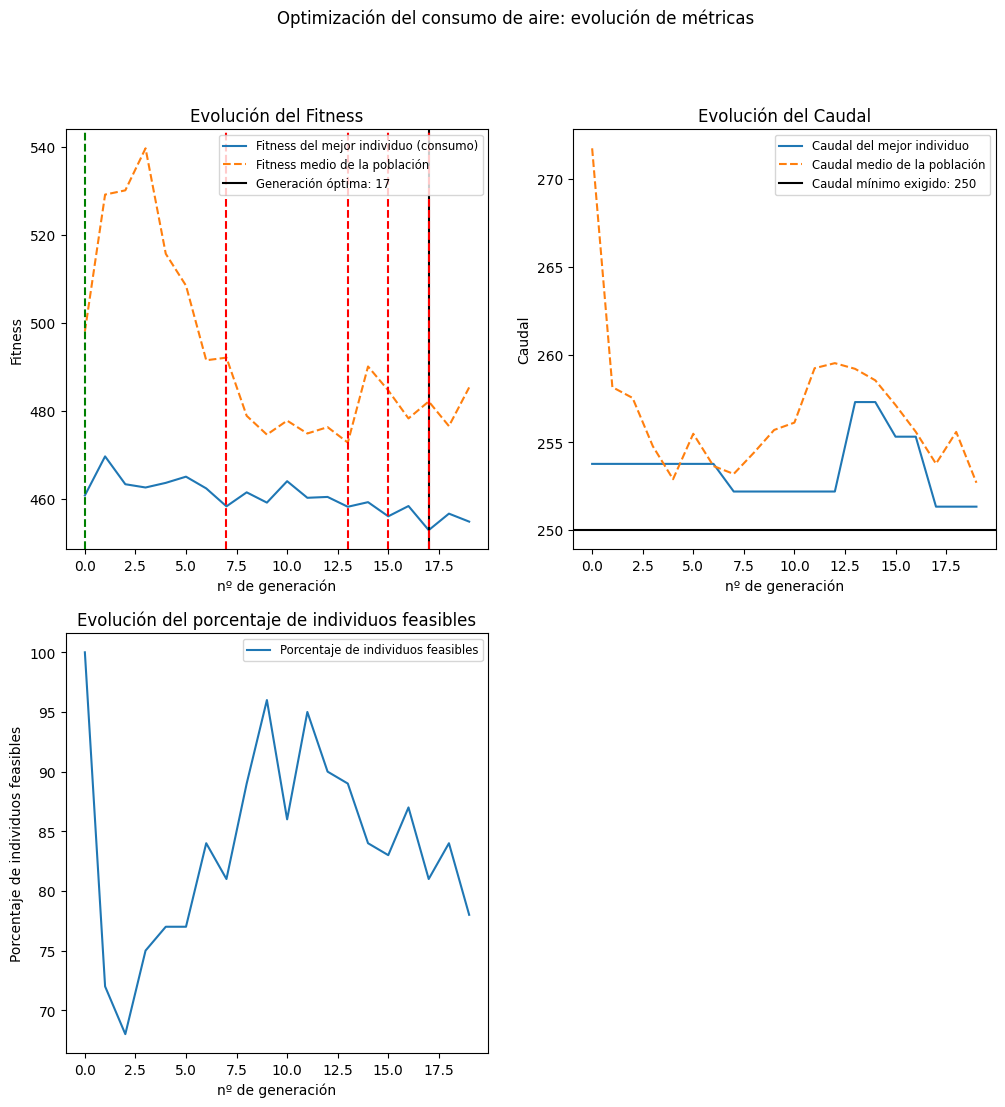

In [ ]:
# Main con Differential Evolution
best_individual, best_fitness, poblacion = opt.main_diff_evolution(N_GENERATIONS, N_INDIVIDUOS, PRODUCCION, MIN_PRODUCCION, compresores, modelos, colec_opt)

#### Nuevo escenario: aumento del caudal mínimo exigido

452.84008817837395 antes
[86.1056256, 17.431833599999994, 83.05767424000001, 64.21690163199999] [86.1056256, 17.431833599999994, 83.05767424000001, 64.21690163199999] 0
452.84008817837395 despues
455.57360275935565 antes
[86.1056256, 17.431833599999994, 83.05767424000001, 64.21690163199999] [86.1056256  17.4318336  83.08998431 89.07659803] 2
461.57360275935565 despues
No ha mejorado con la búsqueda local
Generación 1: Mejor individuo: [86.1056256, 17.431833599999994, 83.0899843072, 89.07659803443202], Mejor fitness: 461.57360275935565, Caudal del mejor: 278.7140187697152, Fitness medio: 531.0306463819684, Caudal medio: 254.69996400094297, Feasibles (%): 28.999999999999996
456.1768579815338 antes
[86.1056256, 17.431833599999994, 83.05767424000001, 64.21690163199999] [62.44685824 22.2247424  83.94513818 84.7632    ] 4
468.1768579815338 despues
Generación 2: Mejor individuo: [86.1056256, 17.431833599999994, 83.0899843072, 89.07659803443202], Mejor fitness: 461.57360275935565, Caudal del m

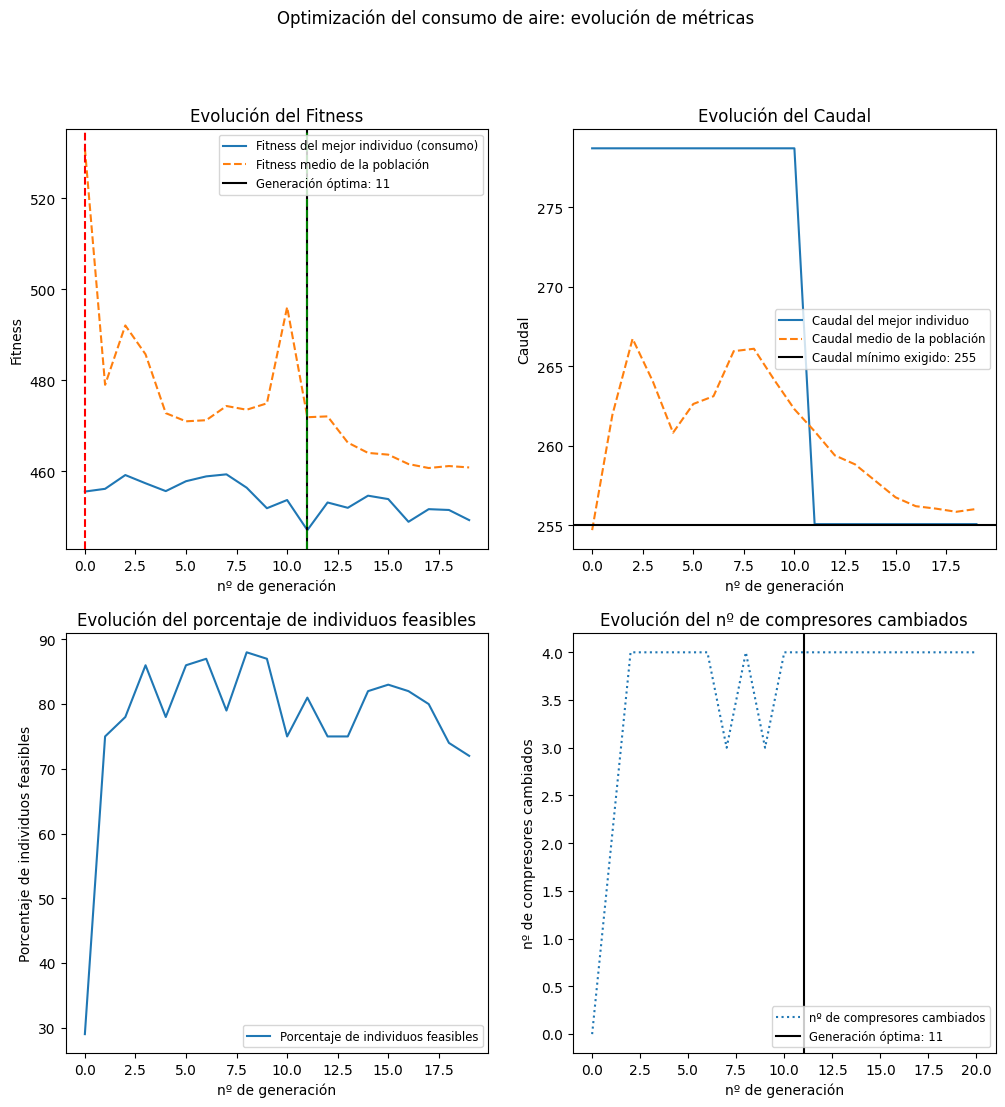

In [ ]:
# Main con un nuevo caudal mínimo: nuevo algoritmo para ver cuántas modificaciones hay que realizar
individuo_anterior = best_individual.copy()
NUEVO_MIN_CAUDAL = 255
opt.main_modificaciones(N_GENERATIONS, PRODUCCION, NUEVO_MIN_CAUDAL, poblacion, best_fitness, compresores, modelos, individuo_anterior, colec_opt)

#### Queries sobre los resultados mediante MongoDB

In [ ]:
# Query 1: Obtener el mejor fitness del algoritmo de optimización de la categoría "post_modificaciones"
query1 = colec_opt.find_one({'categoria': 'post_modificaciones'}, {'_id': 0, 'results.mejor_resultado.fitness': 1})
print(f'El MEJOR fitness para la categoría "post_modificaciones" ha sido: {query1["results"]["mejor_resultado"]["fitness"]}\n')

# Query 2: Obtener el mejor individuo del algoritmo de optimización de la categoría "post_modificaciones"
query2 = colec_opt.find_one({'categoria': 'post_modificaciones'}, {'_id': 0, 'results.mejor_resultado.individuo': 1})
print(f'El MEJOR individuo para la categoría "post_modificaciones" tiene las siguientes frecuencias: {query2["results"]["mejor_resultado"]["individuo"]}\n')

El MEJOR fitness para la categoría "post_modificaciones" ha sido: 447.09598865748603

El MEJOR individuo para la categoría "post_modificaciones" tiene las siguientes frecuencias: [62.44685823999999, 11.466955902840986, 88.40339286897917, 89.38827896832001]



In [ ]:
# Query 3: Comparar los resultados de fitness medios de las dos opciones de algoritmos
query3 = list(colec_opt.aggregate([
    {"$match": {"$or": [{"categoria": "selection_xover_mutation"}, {"categoria": "diff_evolution"}]}},
    {"$project": {"categoria": 1, "fitness_medio": "$results.fitness_medio"}}
]))
print(f'Los resultados de fitness MEDIOS de las dos opciones de algoritmos son: \n{pd.DataFrame(query3)[["categoria", "fitness_medio"]]}\n')

Los resultados de fitness MEDIOS de las dos opciones de algoritmos son: 
        categoria  fitness_medio
0  diff_evolution     485.278888



In [ ]:
# Query 4: Obtener el algoritmo con más porcentaje de individuos factibles
query4 = colec_opt.find({}, {"_id": 0, "categoria": 1, "results.perc_feasible": 1}).sort("results.perc_feasible", -1).limit(1)
query4 = list(query4)[0]
print(f'El algoritmo con más porcentaje de individuos factibles es el {query4["categoria"]}, con un {query4["results"]["perc_feasible"]}% de individuos factibles\n')

El algoritmo con más porcentaje de individuos factibles es el diff_evolution, con un 78.0% de individuos factibles



In [ ]:
# Query 5: Comparar cuántos compresores cambian entre las mejores soluciones de las dos opciones de algoritmos
option_2 = colec_opt.find_one({"categoria": "diff_evolution"}, {"_id": 0, "results.mejor_resultado.individuo": 1})
option_2_individuo = option_2.get("results", {}).get("mejor_resultado", {}).get("individuo", [])

option_3 = colec_opt.find_one({"categoria": "post_modificaciones"}, {"_id": 0, "results.mejor_resultado.individuo": 1})
option_3_individuo = option_3.get("results", {}).get("mejor_resultado", {}).get("individuo", [])

n_cambios = sum(i != j for i, j in zip(option_2_individuo, option_3_individuo))
print(f'{n_cambios} compresores cambian al aumentar el caudal mínimo exigido.')

4 compresores cambian al aumentar el caudal mínimo exigido.
